# Identifying 10 regions similar to Moscow for Wine Sales

## Executive summary
Market research shows the Russian wine market growing at 13% annually since 2015.  
Furthermore, spending on wine has increased at 20.9% annually. 
Thus, it is a great opportunity for wine retail to catch on the wave and expand sales, especially in undeveloped markets. 

Following the successful wine campaign in Moscow, the company would like to find the top 10 regions with similar buying habits, to have successful wine promotions.  In this report, we found the 10 most similar regions are (in order of similarity): 
* Tver Oblast
* Sverdlovsk Oblast, Kaliningrad Oblast, Yaroslavl Oblast, Chukotka Autonomous Okrug, Pskov Oblast, Primorsky Krai, Republic of Karelia, Kaluga Oblast and Novgorod Oblast.

How was the analysis conducted?
1. Understanding the similarity in wine sales by volume between Moscow and other regions
2. Understanding the trends of alcohol sales in Moscow vs the nation, broken down by type
3. Understanding the similarity in market share of wine sales between Moscow and other regions
4. Feature engineering to capture alcohol buying habits
- Regional mean of recent alcohol sales by type
- Regional market share of recent wine sales
- Correlation of alcohol sales in a region with Moscows by type
5. Clustering to find similar regions to Moscow

## Contents
1. Understand the Dataset
2. Exploratory Data Analysis
3. Feature Engineering
4. Data Pre-processing
5. Clustering and visualization
6. Outcome and conclusion
7. Future work 

## The Dataset
The marketing team has sourced you with historical sales volumes per capita for several different drinks types.

**Key Variables**  
"year" - year (1998-2016)
"region" - name of a federal subject of Russia. It could be oblast, republic, krai, autonomous okrug, federal city and a single autonomous oblast  
"wine" - sale of wine in litres by year per capita  
"beer" - sale of beer in litres by year per capita  
"vodka" - sale of vodka in litres by year per capita  
"champagne" - sale of champagne in litres by year per capita  
"brandy" - sale of brandy in litres by year per capita  

In [2]:
# importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# from scipy.cluster.hierarchy import linkage, dendrogram

sns.set()
random_seed = 31
ref_region = 'Moscow'

In [3]:
raw_df = pd.read_csv(r'./data/russian_alcohol_consumption.csv')
df = raw_df.copy()
df['year'] = pd.to_datetime(df.year , format =*%Y')
df['region'] = df.region.astype('category')

df.sample(5, random_state=random_seed)



,year,region,wine,beer,vodka,champagne,brandy
1404,2014-01-01,Novgorod Oblast,12.0,53.7,10.5,2.0,1.0
656,2005-01-01,Sakhalin Oblast,6.9,39.5,19.1,2.2,1.0
157,1999-01-01,Tyumen Oblast,4.1,34.4,13.5,0.7,0.3
472,2003-01-01,Orenburg Oblast,2.5,28.7,8.5,0.6,0.2
131,1999-01-01,Omsk Oblast,7.5,36.0,16.6,1.1,0.5


## Exploratory data analysis

First, we search the dataset for any missing data that will severely affect the analysis.

In [4]:
segments = ['wine' ,*beer' , 'vodka' , 'champagne', 'brandy']
missing_df = df[df.isna().any(axis=1)]
print(missing_df.region.value_counts() , df.region.value_counts())

Chechen Republic          19
Sevastopol                16
Republic of Crimea        16
Republic of Ingushetia    15
Altai Krai                 0
                          ..
Kurgan Oblast              0
Krasnoyarsk Krai           0
Krasnodar Krai             0
Kostroma Oblast            0
Zabaykalsky Krai           0
Name: region, Length: 85, dtype: int64 Altai Krai                  19
Republic of Karelia         19
Sakha (Yakutia) Republic    19
Saint Petersburg            19
Ryazan Oblast               19
                            ..
Kurgan Oblast               19
Krasnoyarsk Krai            19
Krasnodar Krai              19
Kostroma Oblast             19
Zabaykalsky Krai            19
Name: region, Length: 85, dtype: int64


There are 4 regions in the dataset with many missing observations:  
* Chechen Republic
* Sevastopol
* Republic of Crimea
* Republic of Ingushetia  

We will remove data for these regions.

In [5]:
filter = df.region.isin( ['Republic of Ingushetia',
 'Republic of Crimea',
 'Sevastopol',
 'Chechen Republic'])
repaired_df = df[~filter].copy()
repaired_df['region'] = repaired_df.region.cat.remove_unused_categories()
# print(len(repaired_df), len(df))

Next, we look at the wine sales by region for 2015 and 2016.  
This could be one of the aspects of buying habits.

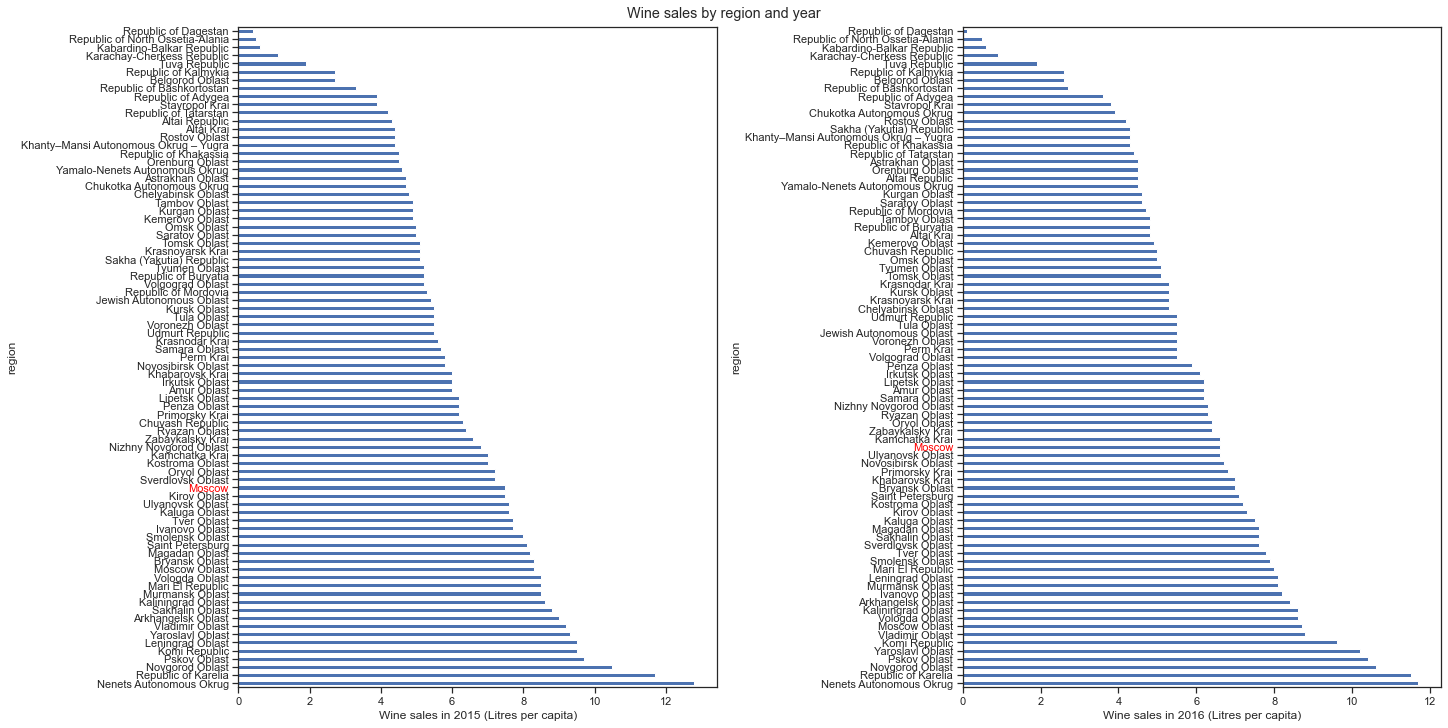

In [29]:
fig, axes = plt.subplots(1,2, figsize=(20,10), constrained_layout=True)
plt.suptitle('Wine sales by region and year')

def highlight_region(ax) :
    for text in ax.yaxis.get_ticklabels() :
        if text.get_text() == ref_region :
            text.set_color('red')

def plot_wine_sales(year, ax) :
    # ax = axes[0]
    plot_df = repaired_df[ repaired_df['year'] == year 
        ].set_index('region')['wine'].sort_values(ascending=False)
    ax.set_xlabel(f'Wine sales in {year} (Litres per capita)')
    # with sns.color_palette('husl') :
    plot_df.plot(kind='barh', ax = ax )
    highlight_region(ax)

plot_wine_sales('2015', axes[0])
plot_wine_sales('2016', axes[1])

We can see that there are regions with similar wine consumption to the target region in 2015 and 2016.  
However they are different - in 2015, the most similar regions were 
* Orygl Oblast
* Sverdiovsk Oblast
* Kirov Oblast
* Ulyanovsk Oblast
* Kaluga Oblast.  

In 2016, the most similar regions were 
* ZabayKalsky Kraj
* Kamchatka Kraj
* Ulyanovsk Oblast
* Novosibirsk Oblast 
* Primorsky Kraj.


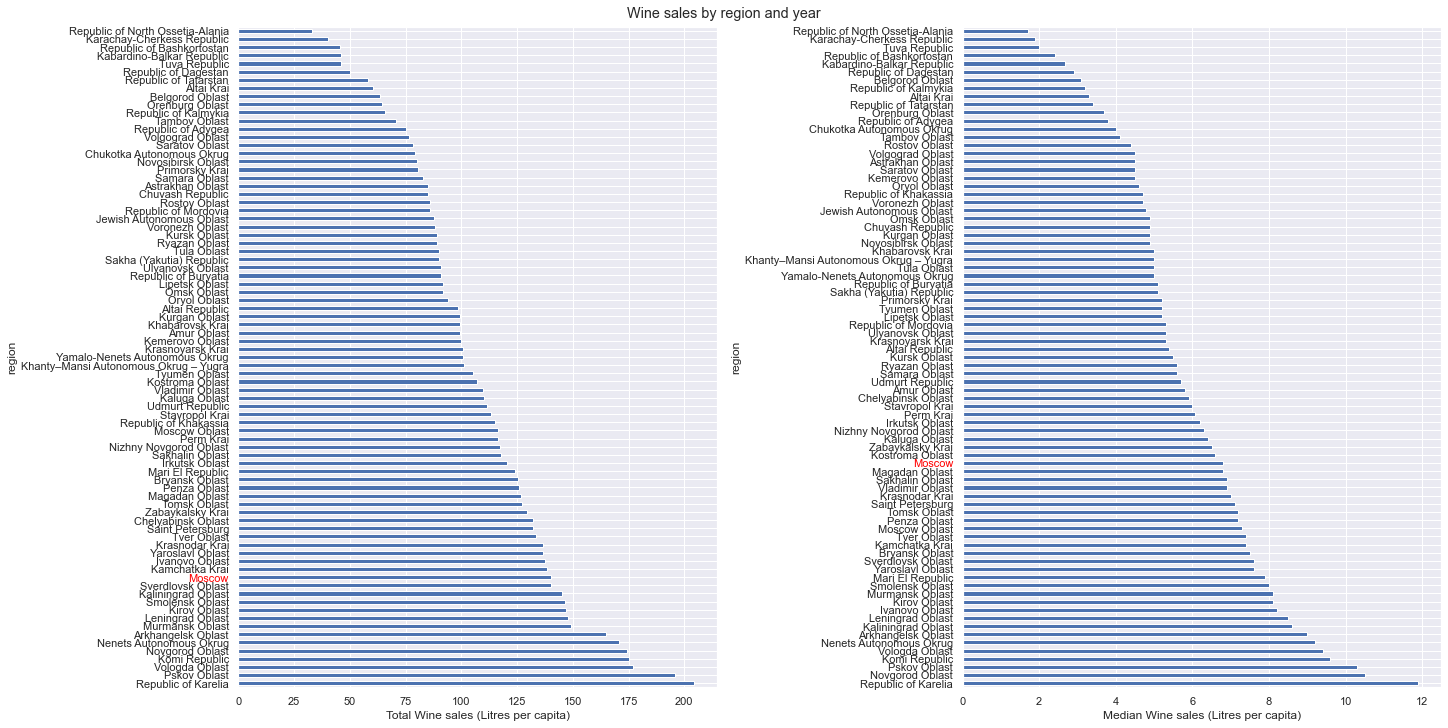

In [8]:
fig, axes = plt.subplots(1,2, figsize=(20,10), constrained_layout=True)
plt.suptitle('Wine sales by region and year')



ax = axes[0]
plot_df = repaired_df.groupby('region').sum()['wine'].sort_values(ascending=False)
ax.set_xlabel(f'Total Wine sales (Litres per capita)')
plot_df.plot(kind='barh', ax=ax)
highlight_region(ax)

ax = axes[1]
plot_df = repaired_df.groupby('region').median()['wine'].sort_values(ascending=False)
ax.set_xlabel(f'Median Wine sales (Litres per capita)')
plot_df.plot(kind='barh', ax=ax)
highlight_region(ax)


Intutively, there are also regions with similar total and median wine consumption to the target region.  
Again, the regions which are similar when dealing with a different aggregation.  
This could be one of the aspects of buying habits.  
Note also that Moscow has higher than average total and median wine sales.  


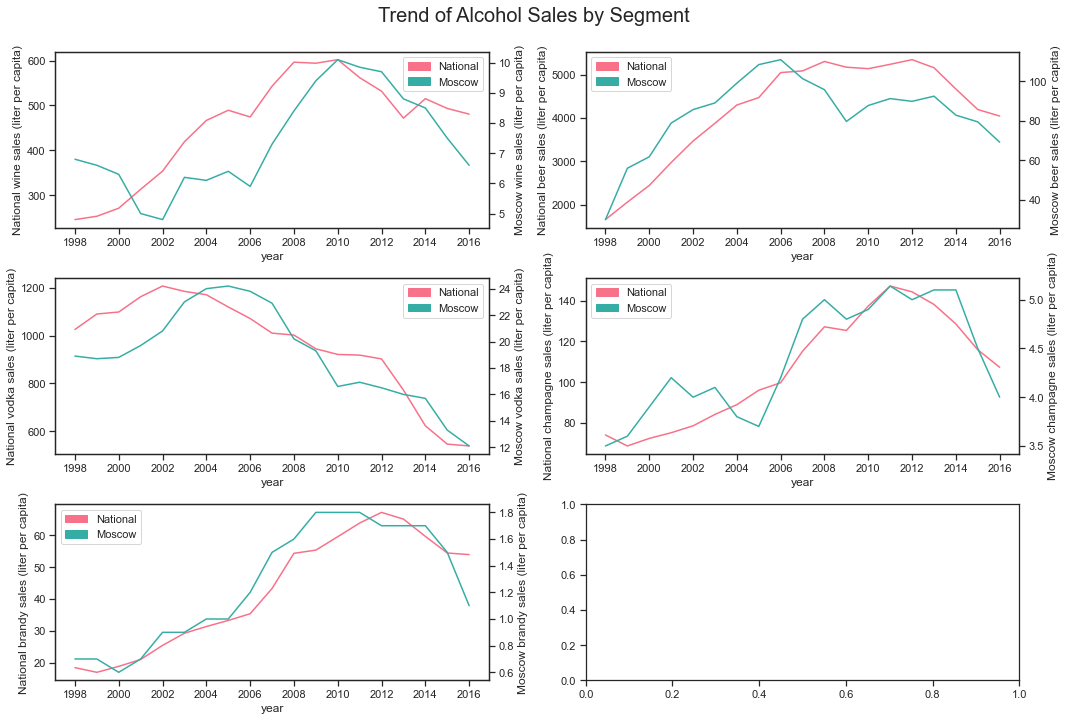

In [49]:
import matplotlib as mpl 

fig, axs = plt.subplots(3,2,figsize=(15,10),sharex=False)
fig.suptitle('Trend of Alcohol Sales by Segment', y=1 , fontsize = 20)
cmap = sns.color_palette('husl', 2)

ref_df = repaired_df[ repaired_df['region'] == ref_region]
national_df = repaired_df.groupby('year').sum()
for i, segment in enumerate(segments):
    ax = axs[i//2, i%2]
    sns.lineplot(x='year', y= segment , data = national_df, ax = ax, label = 'National', color=cmap[0])
    ax.set_ylabel(f'National {segment} sales (liter per capita)')
    ax.legend(handles=[
        mpl.patches.Patch(color=cmap[0], label='National'),
        mpl.patches.Patch(color=cmap[1], label=ref_region),
    ])
    ax2 = ax.twinx()
    sns.lineplot(x='year', y= segment , data = ref_df, ax = ax2, color=cmap[1] )
    ax2.set_ylabel(f'{ref_region} {segment} sales (liter per capita)')

plt.tight_layout()

* For wine sales trend, we see that Moscow is slightly different from the national total.  Moscow declines to a low in 2002, this is not seen nation-wide.  Moscow peaks later than the nation in 2010, before declining like the rest of the nation.  
* For beer sales trend, Moscow is also slightly different from the national total.  Moscow peaks earlier in 2006.  Moscow beer also declines to a lower level unlike the national total.  However, Moscow beer sales is the highest volume of alcohol, same as the nation.  
* For vodka sales trend, Moscow is more similar to the national total.  Moscow peaks later in 2005, before declining like the rest of the nation.  
* For champagne sales trend, Moscow's is more erratic than the nation.  It is most similar between 2007 and 2015 when it is on an increase.  
* For brandy sales trend, Moscow is more similar to the national total.  Moscow peaks earlier in 2009.  Moscow brandy also declines much more sharply in 2016 than the nation.  

The trends of alcohol consumption by type can also be one of the aspects of the buying habits.

All the distributions display a bell shape, which is a good characteristic. Anyway, for further analysis, it would be better if a logarithmic transformation is made. It wouldn't change the characteristics of our data but it will improve the performance of the predictive model.
Skewed right

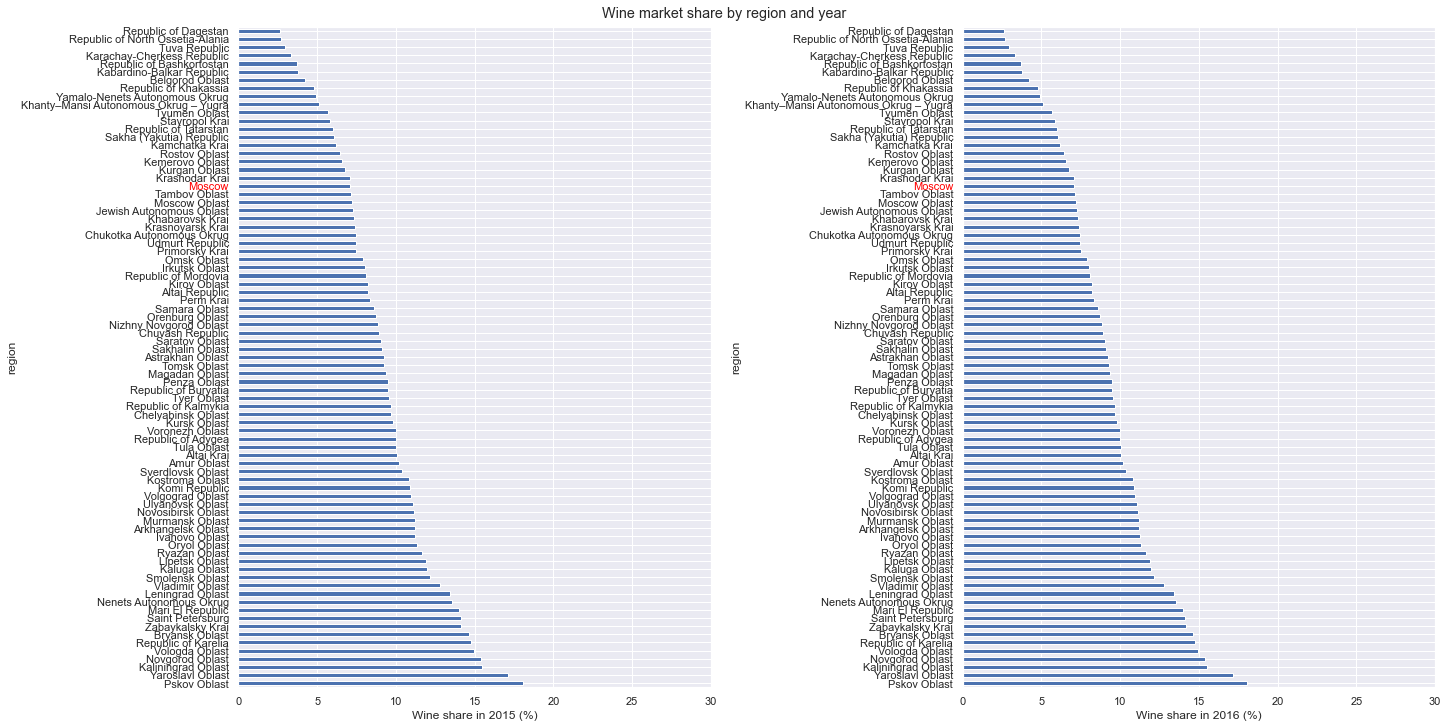

In [10]:
fig, axes = plt.subplots(1,2, figsize=(20,10), constrained_layout=True)
plt.suptitle('Wine market share by region and year')
def plot_wine_share(year, ax) :
    plot_df = repaired_df[ repaired_df['year'] == '2016' 
            ].set_index('region')
    plot_df['wine_share'] = plot_df.apply( 
        lambda row : 100 * row['wine'] / (row['wine'] + row['beer'] + row['vodka'] + row['champagne'] + row['brandy']), 
        axis=1,
    )
    ax.set_xlabel(f'Wine share in {year} (%)')
    ax.set_xlim(0, 30)
    series = plot_df['wine_share'].sort_values(ascending=False)
    series.plot(kind='barh', ax = ax )
    highlight_region(ax) 

plot_wine_share('2015', axes[0])
plot_wine_share('2016', axes[1])

We see that there are regions with the same share of wine sales as in Moscow in 2015, 2016.  
Regions with a similar market share may be a good fit for a similar promotion as in Moscow.  
This can be an aspect of the buying habits too.
However, Moscow has a lower than average market share.  
Selling to regions with high market share for wine may be more profitable! 


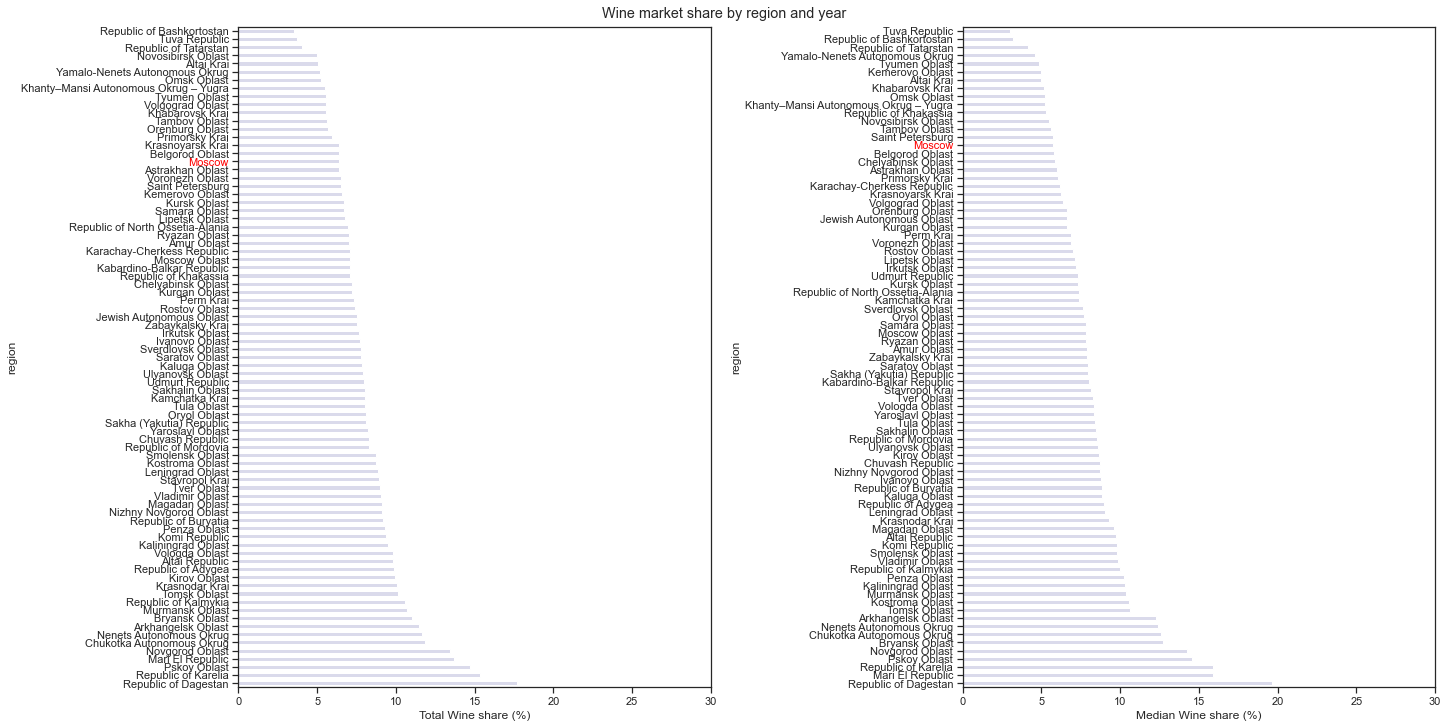

In [45]:
fig, axes = plt.subplots(1,2, figsize=(20,10), constrained_layout=True)
plt.suptitle('Wine market share by region and year')
cmap = sns.color_palette('husl', 5)

ax = axes[0]
ax.set_xlabel(f'Total Wine share (%)')
ax.set_xlim(0, 30)
plot_df = repaired_df.groupby('region').sum()
plot_df['wine_share'] = plot_df.apply( 
    lambda row : 100 * row['wine'] / (row['wine'] + row['beer'] + row['vodka'] + row['champagne'] + row['brandy']), 
    axis=1,
)
series = plot_df['wine_share'].sort_values(ascending=False)
series.plot(kind='barh', ax = ax )
highlight_region(ax) 

ax = axes[1]
ax.set_xlabel(f'Median Wine share (%)')
ax.set_xlim(0, 30)
plot_df = repaired_df.groupby('region').median()
plot_df['wine_share'] = plot_df.apply( 
    lambda row : 100 * row['wine'] / (row['wine'] + row['beer'] + row['vodka'] + row['champagne'] + row['brandy']), 
    axis=1,
)
series = plot_df['wine_share'].sort_values(ascending=False)
series.plot(kind='barh', ax = ax )
highlight_region(ax) 

We see that there are regions with the same share of total / median wine sales as in Moscow.  
This can be an aspect of the buying habits too.

**Conclusion**

1. We found that the trend of alcohol sales in Moscow is slightly different from the national total.
2. However, there are regions that have a similar volume of wine sales in Moscow in certain years.
3. The regions are different for different years, and also for the median and total sales.
4. There are also regions that have a similar market share for wine to Moscow.
5. The exploration has shown that while similarity exists, picking out the most similar regions will not be straightforward.
6. Clustering seems to be a good mechanism to use to assess the similarity.



## Feature Engineering

To do clustering, we will need to have one row of data for each region summarizing its buying habits.
This is not the case now, so we do some feature engineering to create the feature dataset.

Our methodology -  
* aggregate the data to find the median sales for each segment for the last ten years.
* calculate the market share of wine in that region over the last ten years.
* calculate the correlation coefficeint between the sales trend in the region and the reference region 


In [12]:
filtered_df = repaired_df[repaired_df['year'] > '2006']
features_df = filtered_df.set_index('year').groupby('region').mean()

features_df['wine_sales_share'] = features_df.apply (lambda row : 
    row['wine'] / (row['wine'] + row['beer'] + row['vodka'] + row['champagne'] + row['brandy']), 
    axis = 1,
)

features_df.columns = ['mean_wine_sales', 'mean_beer_sales', 'mean_vodka_sales', 
    'mean_champagne_sales', 'mean_brandy_sales', 'wine_sales_share', ]


In [13]:
def get_corr(type, region1, region2) :
    return np.corrcoef(
        repaired_df[ repaired_df['region'] == region1 ][type],
        repaired_df[ repaired_df['region'] == region2 ][type], 
    )[0,1]

for region in features_df.index :
    for type in ['wine', 'beer', 'brandy', 'vodka', 'champagne',] :
        features_df.loc[region, type + '_sales_corr'] = get_corr(type, 'Saint Petersburg', region)

features_df.loc['Saint Petersburg']
features_df



,mean_wine_sales,mean_beer_sales,mean_vodka_sales,mean_champagne_sales,mean_brandy_sales,wine_sales_share,wine_sales_corr,beer_sales_corr,brandy_sales_corr,vodka_sales_corr,champagne_sales_corr
region,,,,,,,,,,,
Altai Krai,4.091,55.079,7.835,1.244,0.330,0.059654,0.276863,0.366096,0.531882,0.597115,0.394560
Altai Republic,5.051,51.256,9.359,0.996,0.392,0.075327,0.209446,0.210930,0.574049,0.590447,0.516061
Amur Oblast,6.471,68.257,10.972,1.530,0.544,0.073723,0.702777,0.285400,0.418090,0.935857,0.385761
Arkhangelsk Oblast,10.283,46.320,14.654,2.069,1.024,0.138305,0.737251,0.196827,0.403663,0.640373,0.655651
Astrakhan Oblast,4.922,65.701,7.714,0.957,0.536,0.061656,0.538794,0.468743,0.468021,0.828015,0.575155
...,...,...,...,...,...,...,...,...,...,...,...
Vologda Oblast,9.704,77.163,13.534,1.149,0.584,0.095012,0.434099,0.576139,0.459739,0.832865,0.347676
Voronezh Oblast,6.122,70.581,8.541,1.710,0.544,0.069967,0.598658,0.308412,0.775293,0.661791,0.432214
Yamalo-Nenets Autonomous Okrug,6.113,90.602,12.407,2.053,1.418,0.054293,0.502499,0.439537,0.491995,0.895975,0.510564


## Data Pre-Processing
The dataset is in the right format for clustering.  
Before doing that, we check the distribution of the features.

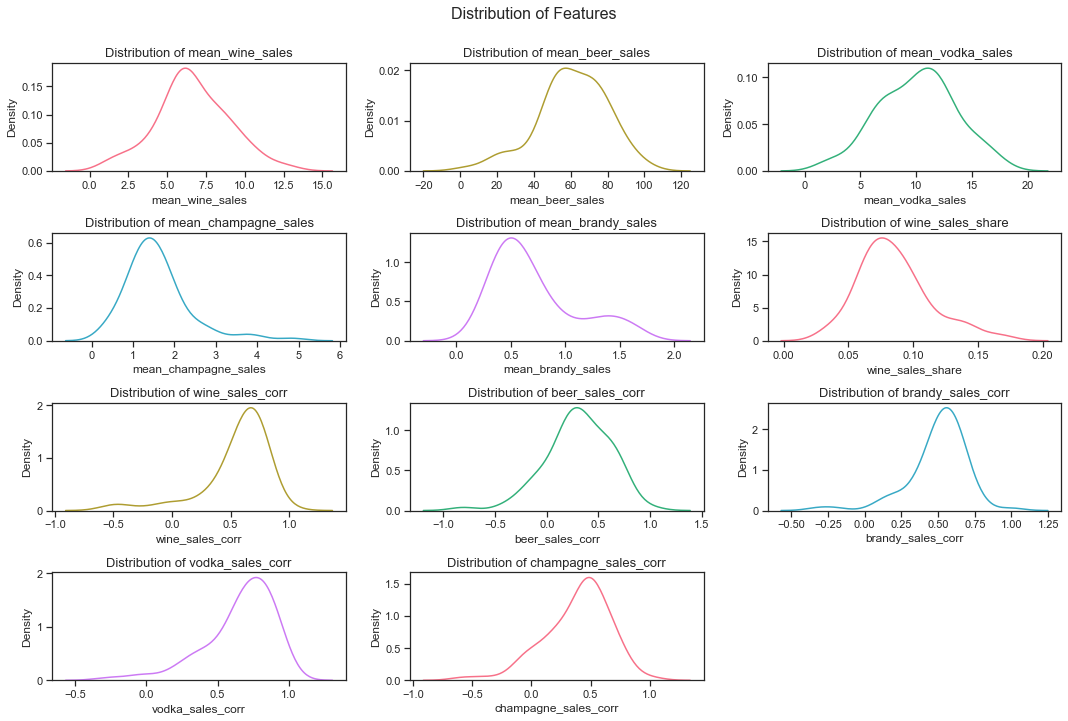

In [43]:
#Looking for distributions 
fig = plt.figure(figsize=(15, 10))
cmap = sns.color_palette('husl', 5)
for i, col in enumerate(features_df.columns):
    # Plot lineplot 
    plt.subplot(4,3,i+1)
    sns.kdeplot( features_df[col], color=cmap[i%5]);
    plt.title(f'Distribution of {col}', fontsize=13)
fig.suptitle('Distribution of Features',y=1, fontsize=16)
plt.tight_layout()

We see the features *['mean_beer_sales', 'mean_brandy_sales', 'beer_sales_corr', 'champagne_sales_corr']* are skewed.  
In addition, the features *['mean_champagne_sales', 'wine_sales_corr', 'brandy_sales_corr', 'vodka_sales_corr']* seem to follow an exponential distribution.  
These will need to be transformed.  
We also need to normalize the features so that the mean and variance of each feature is similar.  
This will allow clustering to treat each feature equally.  


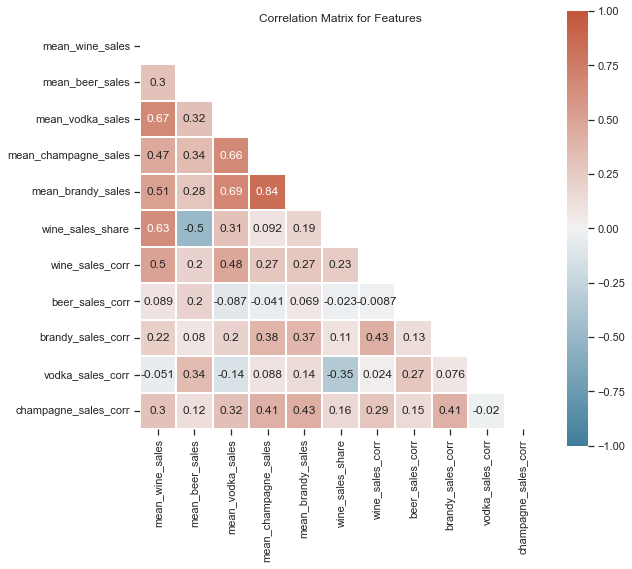

In [50]:
fig, ax = plt.subplots(figsize=(9, 8)) 
corr = features_df.corr(method = 'pearson')
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, 
        mask = mask, 
        cmap = cmap, 
        vmax = 1,                                      # Set scale min value
        vmin = -1,                                     # Set scale min value
        center = 0,                                    # Set scale centre value
        square = True,                                 # Ensure perfect squares
        linewidths = 1.5,                              # Set linewidth between squares
        annot = True ,                                  # Include values within squares
        ax = ax,
        );
_ = ax.set_title('Correlation Matrix for Features')

We see some multicollinearity in the features -  

Strong positive correlation between
* mean_vodka_sales and mean_wine_sales
* mean_vodka_sales and mean_champagne_sales
* mean_vodka_sales and mean_brandy_sales
* mean_champagne_sales and mean_brandy_sales
* wine_sales_share and mean_wine_sales

There are also medium correlations (positive/negative) between ~20 features,  
And weak correlations (positive/negatie) between between ~20 features  
This suggests using dimension reduction methods like PCA.  

In [16]:
from sklearn.preprocessing import PowerTransformer
def power_transform(df , log_cols):
    #apply a log transformation tu a numeric colum
    transformer = PowerTransformer(standardize=False)
    X = df.copy()
    for col in log_cols:
        # X[col] =np.log(X[col] + 1) #Add 1 just to avoid Log(0) that it is not define.
        X[col] = transformer.fit_transform(X[[col]])
    return X 

skewed_cols = ['mean_beer_sales', 'mean_brandy_sales', 'beer_sales_corr', 'champagne_sales_corr']
exp_cols = ['mean_champagne_sales', 'wine_sales_corr', 'brandy_sales_corr', 'vodka_sales_corr'] 
transformed_df = power_transform(features_df, skewed_cols + exp_cols) 


In [17]:
scaler = StandardScaler()
transformed_arr = scaler.fit_transform(transformed_df)
transformed_df2 = pd.DataFrame(
    data = transformed_arr,
    index = features_df.index , 
    columns = features_df.columns
)
transformed_df2

,mean_wine_sales,mean_beer_sales,mean_vodka_sales,mean_champagne_sales,mean_brandy_sales,wine_sales_share,wine_sales_corr,beer_sales_corr,brandy_sales_corr,vodka_sales_corr,champagne_sales_corr
region,,,,,,,,,,,
Altai Krai,-1.104327,-0.383976,-0.665447,-0.330757,-1.298261,-0.935799,-1.318438,0.112337,0.027266,-0.521697,-0.101435
Altai Republic,-0.690976,-0.586651,-0.217214,-0.792510,-0.946957,-0.369398,-1.477002,-0.406942,0.288171,-0.551069,0.405217
Amur Oblast,-0.079561,0.354657,0.257195,0.119095,-0.252987,-0.427359,0.517643,-0.163738,-0.602591,1.565096,-0.136085
Arkhangelsk Oblast,1.561788,-0.839970,1.340130,0.797084,1.027421,1.906468,0.748080,-0.451737,-0.675050,-0.321515,1.053084
Astrakhan Oblast,-0.746520,0.206776,-0.701035,-0.872585,-0.284604,-0.863445,-0.390278,0.482077,-0.339187,0.761304,0.670812
...,...,...,...,...,...,...,...,...,...,...,...
Vologda Oblast,1.312485,0.886151,1.010721,-0.498652,-0.101810,0.341972,-0.828328,0.890835,-0.384254,0.794393,-0.282928
Voronezh Oblast,-0.229831,0.490952,-0.457801,0.366737,-0.252987,-0.563096,-0.092674,-0.086333,1.757339,-0.216023,0.049952
Yamalo-Nenets Autonomous Okrug,-0.233706,1.732819,0.679252,0.779453,1.572403,-1.129530,-0.553465,0.374776,-0.205580,1.250806,0.381153


Now we perform Principal Component Analysis(PCA), which is a technique to address dimensionality reduction and also remove multi-collinearity at the same time.  
It transforms the data in a way with less variables that can express most of the variance.

In [52]:
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(transformed_df2)
#Plot the explained variance
# plt.figure(figsize = (10,5))
# features = range(pca.n_components_)
# plt.bar(features, pca.explained_variance_ratio_ , color = 'blue')
# plt.xlabel('PCA features')
# plt.ylabel('variance %')
# plt.xticks(features)
PCA_components = pd.DataFrame(data = principalComponents , index = transformed_df2.index)

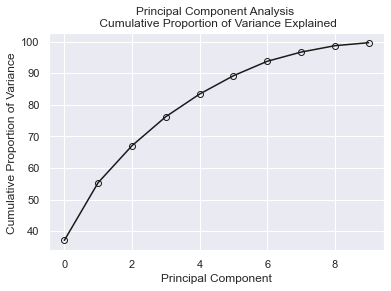

In [20]:
# Assign variance explained
var = pca.explained_variance_ratio_

# Plot cumulative variance
cumulative_var = np.cumsum(var)*100

plt.plot(cumulative_var,'k-o',markerfacecolor='None',markeredgecolor='k')
plt.title('Principal Component Analysis \n Cumulative Proportion of Variance Explained',fontsize=12)
plt.xlabel("Principal Component",fontsize=12)
plt.ylabel("Cumulative Proportion of Variance ",fontsize=12)
plt.show()

From this plot, we see that 6 principal components accounts for >90% of the variance.  
We will be using these components as features for clustering to analyze which regions are similar.  
We note that we have only 81 observations (rows) in our transformed data.  
To avoid overfitting the model, we use only 4 principal components which can account for >80% of the the variance.


In [53]:
chosen_PCA_components = PCA_components.iloc[:, :3].copy()

# plt.figure(figsize = (10,10))
# ax = plt.gca()
# plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
# plt.scatter(PCA_components.loc[ref_region][0], 
#             PCA_components.loc[ref_region][1], 
#             color = 'red', label = ref_region)
# circle = plt.Circle((PCA_components.loc[ref_region][0], 
#                       PCA_components.loc[ref_region][1]), 
#                      1, color='b', 
#                      ls = '--',
#                      fill=False)
# ax.add_patch(circle)
# plt.legend()
# plt.xlabel('PCA 1')
# plt.ylabel('PCA 2')

## Clustering
Clustering refers to a very set of techniques for finding subgroups in a data set?.  
The goal is that the observation within every group were similar to each other.  
In K-means clustering we look to find K non-overlapping clusters, wherein every group the variation between the cluster members should be small as possible.

One of the problems of this clustering method is to address the question about how many clusters exist?  
Too many clusters should cause overfitting but too little should cause biased conclusions.  
To answer this question one should do an elbow analysis, in which you should choose the number of clusters that gives a high reduction of the inertia ( inertia is a measure of how coherent is every cluster internally).

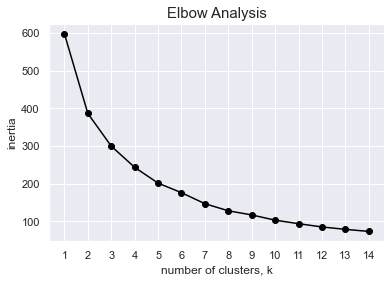

In [22]:

import warnings

ks = range(1, 15)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    with warnings.catch_warnings():
        warnings.simplefilter('ignore') # ignore UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads.
        model = KMeans(n_clusters=k)
        model.fit(chosen_PCA_components)
        inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.title('Elbow Analysis', fontsize = 15)
plt.show()

Looking at the elbow analysis, we should conclude that using 5 or 6 clusters would be okay, additional clusters don't reduce the inertia too much.

In [55]:
km = KMeans(n_clusters=5) 
km.fit(chosen_PCA_components)
centers = km.cluster_centers_
label = km.predict(chosen_PCA_components)
chosen_PCA_components['label'] = label
sp_label = chosen_PCA_components.loc[ref_region,'label']

T-distributed stochastic neighbor embedding (t-SNE) is a tool that maps high-dimensional data to 2 or 3 dimensions.
We use it to visualize the clustering analysis.  
Note that the axis of the plot do not have any interpretable meaning.

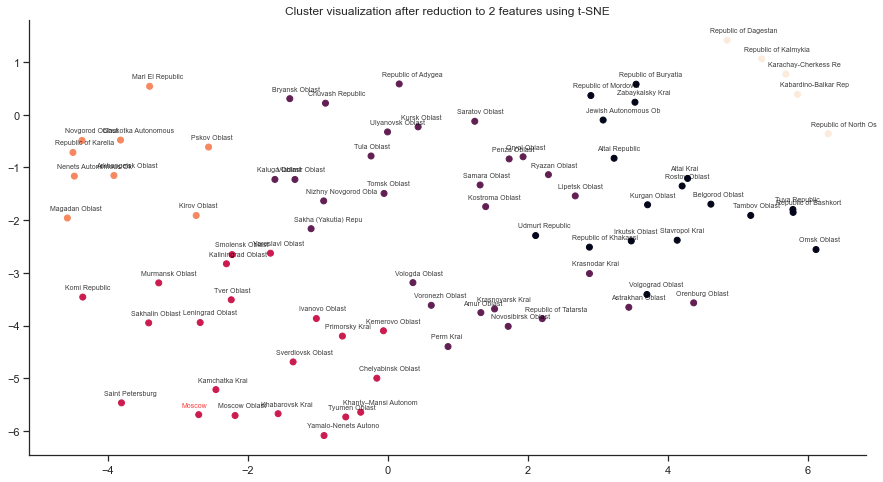

In [58]:
from sklearn.manifold import TSNE 
model = TSNE(init='random', learning_rate='auto', random_state=random_seed )
tsne_features = model.fit_transform(
    chosen_PCA_components.drop('label', axis=1)
)
xs = tsne_features[:,0]
ys = tsne_features[:,1]

plt.figure( figsize=(15,8))
plt.scatter(
    xs, ys,
    c = chosen_PCA_components['label']
)
plt.title('Cluster visualization after reduction to 2 features using t-SNE')

regions = chosen_PCA_components.index
for x,y,region in zip(xs, ys,regions) :
    if region == ref_region :
        color = 'red'
    else :
        color = 'black'
    plt.annotate(region[:20], (x-0.25, y+0.15), alpha=0.75, fontsize=7, color=color, )

sns.despine()
# plt.xlim(2,6)
# plt.ylim(-6, 0)


## Outcome and Conclusion

Clustering has given us regions similar to the reference region.  
The similarity is based on the engineered features which summarize the alcohol buying habits, after transformation.  
As the cluster has more than 11 regions, we need to select the top 10 nearest regions to the reference region. 


In [ ]:
tsne_df = pd.DataFrame(tsne_features, index=chosen_PCA_components.index)
tsne_df.columns = ['x', 'y']
origin_region_x, origin_region_y = tsne_df.loc[ref_region]

tsne_df['distance'] = tsne_df.apply( 
    lambda row : (row['x'] - origin_region_x) ** 2 + (row['y'] - origin_region_y) ** 2, 
    axis=1, )
tsne_df.sort_values('distance')[1:11].index.to_list()


['Moscow Oblast',
 'Kamchatka Krai',
 'Saint Petersburg',
 'Khabarovsk Krai',
 'Sverdlovsk Oblast',
 'Leningrad Oblast',
 'Yamalo-Nenets Autonomous Okrug',
 'Sakhalin Oblast',
 'Tyumen Oblast',
 'Tver Oblast']

In [ ]:
# plt.figure(figsize=(12,12))
# sns.scatterplot(x=0, y= 1 , 
#                 data = chosen_PCA_components,
#                 alpha = 0.1,
#                 color = 'black')
# sns.scatterplot(x=chosen_PCA_components.loc[chosen_PCA_components.label==sp_label][0],
#                 y=chosen_PCA_components.loc[chosen_PCA_components.label==sp_label][1], 
#                label = ref_region + ' Cluster')
# plt.scatter(x=chosen_PCA_components.loc[ref_region][0],
#                 y=chosen_PCA_components.loc[ref_region][1],
#                 color = 'red',
#            label = ref_region)
# sns.scatterplot(x=centers[:,0], y=centers[:,1], 
#                 marker='+', 
#                 color='black',
#                 label ='Centroids',
#                 s=200);
# plt.legend(fontsize=20)
# plt.xlabel('PCA 1')
# _ = plt.ylabel('PCA 2')

The top 10 regions most similar in buying habits to Moscow are - 
* Moscow Oblast
* Kamchatka Krai
* Saint Petersburg
* Khabarovsk Krai
* Sverdlovsk Oblast
* Leningrad Oblast
* Yamalo-Nenets Autonomous Okrug
* Sakhalin Oblast
* Tyumen Oblast
* Tver Oblast  
with the top item being the most similar.  


*Conclusion*  
The cluster visualization clearly shows us which regions are closer to Moscow.
As the distance is derived from features which summarize the average alcohol sales by type, the simarity trend of alcohol sales by type with that of Moscow, and the market share of wine sales, we can conclude that the closer regions have more similar alcohol buying habits to Moscow.
It is thus likely that a wine promotion in these regions will have similar success to Moscow.





## Future Work
* Use data for the population of each region
* Experiment to see how successful promotions are in regions which have a much higher wine market share. 